### Sélection des données :
1. Trouver un jeu de données contenant au moins 5000 instances et 20
caractéris7ques (catégorielles, dates, numériques).
2. Le jeu de données doit être validé par l’enseignante avant son utilisation.

In [2]:
from tensorflow.keras.datasets import cifar10
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from mlflow.models import infer_signature
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from skimage import color, exposure
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import numpy as np
import tensorflow as tf
import mlflow
import mlflow.sklearn
from sklearn.decomposition import PCA

In [ ]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
subset_size_train = 5000
subset_size_test = 2000
indices_train = np.random.choice(x_train.shape[0], subset_size_train, replace=False)
indices_test = np.random.choice(x_test.shape[0], subset_size_test, replace=False)
x_train_subset = x_train[indices_train]
y_train_subset = y_train[indices_train]
x_test_subset = x_test[indices_test]
y_test_subset = y_test[indices_test]


In [5]:
x_train_subset.shape

(5000, 32, 32, 3)

In [6]:

x_train_flat = x_train_subset.reshape(x_train_subset.shape[0], -1) / 255.0
x_test_flat = x_test_subset.reshape(x_test_subset.shape[0], -1) / 255.0

In [7]:
print(f"Missing values in training data: {np.isnan(x_train_flat).sum()}")
print(f"Missing values in test data: {np.isnan(x_test_flat).sum()}")


Missing values in training data: 0
Missing values in test data: 0


In [11]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_flat, y_train_subset.ravel())

RandomForestClassifier(random_state=42)

In [12]:
feature_importances = rf.feature_importances_
feature_df = pd.DataFrame({
    "Feature": [f"pixel_{i}" for i in range(len(feature_importances))],
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print(feature_df.head(20))

         Feature  Importance
107    pixel_107    0.001780
200    pixel_200    0.001622
5        pixel_5    0.001143
83      pixel_83    0.001101
71      pixel_71    0.000986
2425  pixel_2425    0.000928
2431  pixel_2431    0.000927
260    pixel_260    0.000900
2428  pixel_2428    0.000885
182    pixel_182    0.000882
1499  pixel_1499    0.000873
203    pixel_203    0.000871
95      pixel_95    0.000870
104    pixel_104    0.000859
14      pixel_14    0.000854
263    pixel_263    0.000852
23      pixel_23    0.000804
101    pixel_101    0.000798
917    pixel_917    0.000795
89      pixel_89    0.000791


In [13]:
top_features = feature_df.index[:500]  
x_train_top = x_train_flat[:, top_features]
x_test_top = x_test_flat[:, top_features]
print(f"Reduced training shape: {x_train_top.shape}, Reduced test shape: {x_test_top.shape}")

Reduced training shape: (5000, 500), Reduced test shape: (2000, 500)


In [12]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(x_train_top, y_train_subset.ravel())


print(f"Best parameters: {grid_rf.best_params_}")
print(f"Best cross-validated accuracy: {grid_rf.best_score_}")


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validated accuracy: 0.38620271143850465


In [11]:
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [None, 10, 20 , 30],
    'min_samples_split': [2, 5 , 10],
    'min_samples_leaf': [1, 2 , 4]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(x_train_top, y_train_subset.ravel())


print(f"Best parameters: {grid_rf.best_params_}")
print(f"Best cross-validated accuracy: {grid_rf.best_score_}")

Best parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Best cross-validated accuracy: 0.40400167265466475


In [13]:
best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(x_test_top)
cm = confusion_matrix(y_test_subset.ravel(), y_pred)



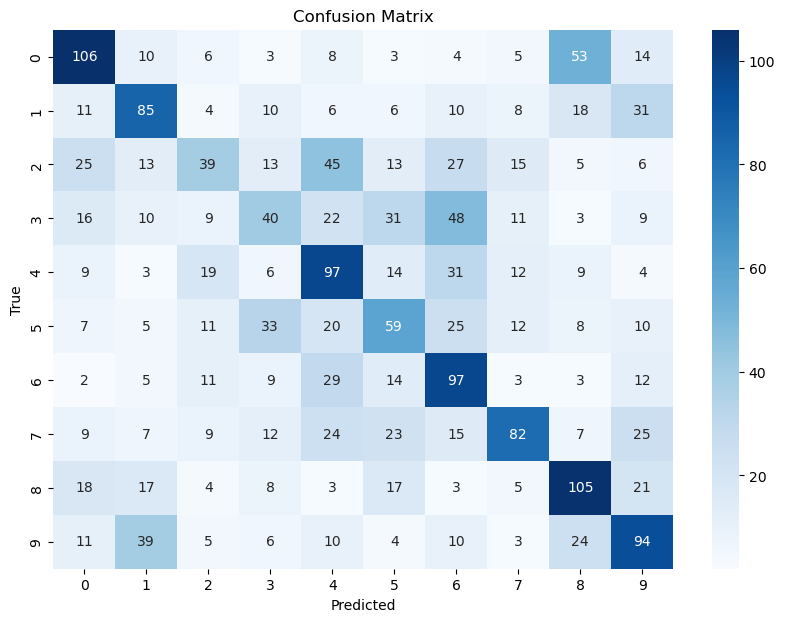

In [14]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print(classification_report(y_test_subset.ravel(), y_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50       212
           1       0.44      0.45      0.44       189
           2       0.33      0.19      0.25       201
           3       0.29      0.20      0.24       199
           4       0.37      0.48      0.41       204
           5       0.32      0.31      0.32       190
           6       0.36      0.52      0.43       185
           7       0.53      0.38      0.44       213
           8       0.45      0.52      0.48       201
           9       0.42      0.46      0.44       206

    accuracy                           0.40      2000
   macro avg       0.40      0.40      0.39      2000
weighted avg       0.40      0.40      0.40      2000



In [ ]:

y_pred_proba = best_rf.predict_proba(x_test_top)
auc_score = roc_auc_score(y_test_subset, y_pred_proba, multi_class='ovr')
print(f"Multiclass AUC (OvR): {auc_score:.4f}")

Multiclass AUC (OvR): 0.8209


In [30]:
mlflow.set_tracking_uri("http://localhost:5000")

## CNN

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

y_train_one_hot = to_categorical(y_train_subset, num_classes=10)
y_test_one_hot = to_categorical(y_test_subset, num_classes=10)

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


def create_cnn_model(learning_rate=0.001, dropout_rate=0.25):
    model = models.Sequential([
        # Bloc 1
        layers.Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 2
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 3
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 4
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Classifieur
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


mlflow.tensorflow.autolog()
mlflow.set_experiment("CNN_classification")


with mlflow.start_run() as run3:
    
    learning_rate = 0.001
    dropout_rate = 0.25


    model = create_cnn_model(learning_rate, dropout_rate)




    history = model.fit(
        x_train_subset, y_train_one_hot,
        validation_split=0.2,
        epochs=2,
        batch_size=32,

    )


    test_loss, test_accuracy = model.evaluate(x_test_subset, y_test_one_hot, verbose=0)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)



 
    y_pred_probs = model.predict(x_test_subset)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_one_hot, axis=1)

 
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

 
    mlflow.log_metric("precision_macro", report['macro avg']['precision'])
    mlflow.log_metric("recall_macro", report['macro avg']['recall'])
    mlflow.log_metric("f1_macro", report['macro avg']['f1-score'])
    mlflow.log_metric("precision_weighted", report['weighted avg']['precision'])
    mlflow.log_metric("recall_weighted", report['weighted avg']['recall'])
    mlflow.log_metric("f1_weighted", report['weighted avg']['f1-score'])

    mlflow.keras.log_model(model, artifact_path="CNN_mdl_cifar")



 
    print("Précision sur les données de test : {:.2f}%".format(test_accuracy * 100))


Epoch 1/2
  6/125 [>.............................] - ETA: 13s - loss: 2.7163 - accuracy: 0.1823WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1162s vs `on_train_batch_end` time: 0.1194s). Check your callbacks.


125/125 [==============================] - 21s 148ms/step - loss: 2.3971 - accuracy: 0.2758 - val_loss: 2.9239 - val_accuracy: 0.1550
Epoch 2/2
1/1 [==============================] - 0s 264ms/step


INFO:tensorflow:Assets written to: C:\Users\niman\AppData\Local\Temp\tmpzkwxkq_7\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\niman\AppData\Local\Temp\tmpzkwxkq_7\model\data\model\assets


63/63 [==============================] - 3s 41ms/step
Classification Report:
              precision    recall  f1-score   support

    Airplane       0.39      0.28      0.32       186
  Automobile       0.37      0.75      0.50       190
        Bird       0.51      0.14      0.22       243
         Cat       0.33      0.20      0.25       207
        Deer       0.40      0.08      0.13       202
         Dog       0.37      0.36      0.36       180
        Frog       0.30      0.70      0.42       183
       Horse       0.58      0.35      0.43       220
        Ship       0.41      0.64      0.50       194
       Truck       0.31      0.34      0.33       195

    accuracy                           0.37      2000
   macro avg       0.40      0.38      0.35      2000
weighted avg       0.40      0.37      0.34      2000



2024/12/11 13:05:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\niman\AppData\Local\Temp\tmp24tz5g1k\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\niman\AppData\Local\Temp\tmp24tz5g1k\model\data\model\assets
2024/12/11 13:05:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Précision sur les données de test : 37.40%
🏃 View run wistful-roo-822 at: http://localhost:5000/#/experiments/2/runs/eaa7b22e44d74e3097aafbd697e6f4f4
🧪 View experiment at: http://localhost:5000/#/experiments/2


### SVM model


In [92]:
import shap
import lime
from lime import lime_tabular
import pickle
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


mlflow.set_experiment("SVM_mdl_cifar")
def extract_hog_features(images):
    hog_features = []
    for image in images:
        
        gray_image = color.rgb2gray(image)
        fd, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)


x_train_hog = extract_hog_features(x_train_subset)
x_test_hog = extract_hog_features(x_test_subset)


experiment_params = [
    {"svm__kernel": "linear", "svm__C": 1.0 , "svm__gamma":0.01},
    {"svm__kernel": "rbf", "svm__C": 10,"svm__gamma":0.01}  
]


pipeline = Pipeline([
    ('scaler', StandardScaler()),   
    ('pca', PCA(n_components=100)), 
    ('svm', SVC(probability=True))  
])


for params in experiment_params:
    with mlflow.start_run() as run1:

        
        mlflow.log_param("kernel", params["svm__kernel"])
        mlflow.log_param("C", params["svm__C"])
        mlflow.log_param("gamma", params["svm__gamma"])

        
        pipeline.set_params(svm__kernel=params["svm__kernel"], svm__C=params["svm__C"], svm__gamma=params["svm__gamma"])
        pipeline.fit(x_train_hog, y_train_subset)
        
        
        y_pred = pipeline.predict(x_test_hog)
        
        accuracy = accuracy_score(y_test_subset, y_pred)
        precision = precision_score(y_test_subset, y_pred, average='weighted')
        recall = recall_score(y_test_subset, y_pred, average='weighted')
        f1 = f1_score(y_test_subset, y_pred, average='weighted')
        
        
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)

        report = classification_report(y_test_subset, y_pred, output_dict=False)
        report_path = "classification_report.txt"
        with open(report_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(report_path)


        cm = confusion_matrix(y_test_subset, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
        plt.title("Confusion Matrix")
        cm_path = "confusion_matrix.png"
        plt.savefig(cm_path)
        plt.close()
        mlflow.log_artifact(cm_path)
        ######################################
        lime_explainer = lime_tabular.LimeTabularExplainer(
            training_data=x_train_hog,
            feature_names=[f"feature_{i}" for i in range(x_train_hog.shape[1])],
            class_names=["Class 0", "Class 1", ..., "Class N"],  
            mode="classification"
        )

        
        for i in range(5):  
            lime_exp = lime_explainer.explain_instance(
                data_row=x_test_hog[i],
                predict_fn=pipeline.predict_proba
            )

           
            explanation_path = f"lime_explanation_{i}.html"
            lime_exp.save_to_file(explanation_path)
            mlflow.log_artifact(explanation_path)

            
            lime_exp.as_pyplot_figure()
            plt.title(f"LIME Explanation for Instance {i}")
            plt.savefig(f"lime_explanation_plot_{i}.png")
            plt.close()
            mlflow.log_artifact(f"lime_explanation_plot_{i}.png")

        #######################################
        
        lime_image_explainer = lime_image.LimeImageExplainer()

        for i in range(5):  
            
            test_image = x_test_subset[i]  
            
            
            def predict_fn(images):
                
                hog_features = extract_hog_features(images)
                return pipeline.predict_proba(hog_features)

            
            lime_image_exp = lime_image_explainer.explain_instance(
                image=test_image,
                classifier_fn=predict_fn,
                top_labels=3,  
                hide_color=0,
                num_samples=1000  
            )

            
            label = pipeline.predict(extract_hog_features([test_image]))[0]
            temp, mask = lime_image_exp.get_image_and_mask(
                label=label,
                positive_only=True,
                hide_rest=False,
                num_features=5,
                min_weight=0.0
            )

            
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.imshow(mark_boundaries(temp / 255.0, mask))  
            ax.set_title(f"LIME Image Explanation for Instance {i}")
            ax.axis('off')
            explanation_image_path = f"lime_image_explanation_{i}.png"
            plt.savefig(explanation_image_path)
            plt.close()
            mlflow.log_artifact(explanation_image_path)

            
            explanation_pickle_path = f"lime_image_explanation_{i}.pkl"
            with open(explanation_pickle_path, "wb") as f:
                pickle.dump(lime_image_exp, f)
            mlflow.log_artifact(explanation_pickle_path)


        ######################################
        mlflow.sklearn.log_model(pipeline, artifact_path="SVM_mdl_cifar")
        
      

c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 1000/1000 [00:07<00:00, 142.35it/s]
2024/12/11 15:45:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


🏃 View run mercurial-carp-940 at: http://localhost:5000/#/experiments/1/runs/69fb690b5dee4e96b7ef8f6159119724
🧪 View experiment at: http://localhost:5000/#/experiments/1


100%|██████████| 1000/1000 [00:07<00:00, 131.27it/s]
2024/12/11 15:47:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run delightful-ant-411 at: http://localhost:5000/#/experiments/1/runs/255ea8ffd5dd4c8497c4a0520463a548
🧪 View experiment at: http://localhost:5000/#/experiments/1


Matrice de confusion

In [ ]:
y_true =y_test_subset  
y_pred = pipeline.predict(x_test_hog)  


conf_matrix = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Labels Prédits")
plt.ylabel("Labels Réels")
plt.title("Matrice de Confusion")


conf_matrix_path = "confusion_matrix.png"
plt.savefig(conf_matrix_path)
plt.close()


with mlflow.start_run(run_id="ddc6621b44a54213997210df6e4913f0"):
    mlflow.log_artifact(conf_matrix_path)


import os
os.remove(conf_matrix_path)

print("La matrice de confusion a été enregistrée avec succès dans MLflow.")

🏃 View run vaunted-grub-385 at: http://localhost:5000/#/experiments/1/runs/ddc6621b44a54213997210df6e4913f0
🧪 View experiment at: http://localhost:5000/#/experiments/1
La matrice de confusion a été enregistrée avec succès dans MLflow.


### Random Forest

In [ ]:

import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import ParameterGrid
import os

param_grid = [
    {'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]} 
]

grid = list(ParameterGrid(param_grid))
for params in grid:
    with mlflow.start_run() as run2:

        rf = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=42
        )

        rf.fit(x_train_top, y_train_subset)
        y_pred = rf.predict(x_test_top)
        
        mlflow.log_param("n_estimators", params['n_estimators'])
        mlflow.log_param("max_depth", params['max_depth'])
        mlflow.log_param("min_samples_split", params['min_samples_split'])
        mlflow.log_param("min_samples_leaf", params['min_samples_leaf'])
        
        
        
        accuracy = accuracy_score(y_test_subset, y_pred)
        auc_score = roc_auc_score(y_test_subset, rf.predict_proba(x_test_top), multi_class='ovr')
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("auc_score", auc_score)
        
        
        mlflow.sklearn.log_model(rf, artifact_path="Random_Forest_Model")
        
        
        report = classification_report(y_test_subset, y_pred, output_dict=False)
        report_path = "classification_report.txt"
        with open(report_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(report_path)
        
        
        cm = confusion_matrix(y_test_subset, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_subset), yticklabels=np.unique(y_test_subset))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        cm_path = "confusion_matrix.png"
        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path)
        plt.close()
        
        
        plt.figure(figsize=(10, 7))
        for i in range(len(rf.classes_)):
            fpr, tpr, _ = roc_curve(y_test_subset == i, rf.predict_proba(x_test_top)[:, i])
            plt.plot(fpr, tpr, label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        roc_path = "roc_curve.png"
        plt.savefig(roc_path)
        mlflow.log_artifact(roc_path)
        plt.close()

    print(f"Run with params {params} saved in {mlflow.get_tracking_uri()}")




c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:37:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run salty-ox-692 at: http://localhost:5000/#/experiments/0/runs/36250a5180cf41eb93c54a33343118cc
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:37:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run tasteful-asp-130 at: http://localhost:5000/#/experiments/0/runs/0bc9ef40c55547c283457e584081f017
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:37:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run industrious-yak-703 at: http://localhost:5000/#/experiments/0/runs/878fc5ba8d784f588c1c24340d2242df
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:37:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run invincible-skunk-883 at: http://localhost:5000/#/experiments/0/runs/19c54236644d45e182a2a3f3ab62ca5d
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:38:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run amazing-lamb-982 at: http://localhost:5000/#/experiments/0/runs/5f55b579a89e426ab3f66351727fc610
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:38:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run nimble-kit-835 at: http://localhost:5000/#/experiments/0/runs/c97e56cb55bf4a53a7ad23ada6b27df9
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:38:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run efficient-goose-189 at: http://localhost:5000/#/experiments/0/runs/e245751d313748c29bd176a4a8d858ae
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:38:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run silent-crow-995 at: http://localhost:5000/#/experiments/0/runs/f885f86434054105b85171e196511034
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:39:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run sneaky-squirrel-592 at: http://localhost:5000/#/experiments/0/runs/d01549bdae4b42eba568f095ec460c5a
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:39:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run luxuriant-tern-866 at: http://localhost:5000/#/experiments/0/runs/bfab936fb10649878173dbac96961bfd
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:39:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run nosy-hawk-21 at: http://localhost:5000/#/experiments/0/runs/e15d00d371ea422a81a1774efd8d412f
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:39:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run adorable-kite-823 at: http://localhost:5000/#/experiments/0/runs/79e9beb8107c49edbda2f92cd4ff2dba
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:39:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run glamorous-stoat-11 at: http://localhost:5000/#/experiments/0/runs/5e90a985bde54df2b2d7ab3bf7300f77
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:40:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run fortunate-goose-584 at: http://localhost:5000/#/experiments/0/runs/fe45ef915af2480fae1cc842709e7166
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:40:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run efficient-rat-549 at: http://localhost:5000/#/experiments/0/runs/974f16c63b844d279d2b6fc4da335bf7
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:40:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run agreeable-perch-749 at: http://localhost:5000/#/experiments/0/runs/b902e385e953486d9af1809962788b70
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:40:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run shivering-roo-666 at: http://localhost:5000/#/experiments/0/runs/3cc61dd1d57741b681c3e645e32ce0a9
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:40:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run judicious-gnu-957 at: http://localhost:5000/#/experiments/0/runs/4e2aaa707b4e404ab36114f23c2ceeba
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:40:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run auspicious-zebra-417 at: http://localhost:5000/#/experiments/0/runs/d3993b5bbac94e40b7cfa480be36768c
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:41:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run capricious-toad-700 at: http://localhost:5000/#/experiments/0/runs/19e7266008b74358a80ba9ade901df9b
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:41:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run gentle-croc-222 at: http://localhost:5000/#/experiments/0/runs/207c831131534a3ebe42c775f50fe93f
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:41:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run gregarious-hound-464 at: http://localhost:5000/#/experiments/0/runs/4962ecf5ebc14bb69efca732b6d3e136
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:41:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run treasured-rook-567 at: http://localhost:5000/#/experiments/0/runs/13d8db5c0a5341dd90e325ed63993443
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:41:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run serious-sponge-608 at: http://localhost:5000/#/experiments/0/runs/5c21b319f0d64fa7bcff79a6a1428e6f
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:41:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run fun-pig-376 at: http://localhost:5000/#/experiments/0/runs/661c3ce97da34c9d88f54001832ea21f
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:42:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run overjoyed-cow-820 at: http://localhost:5000/#/experiments/0/runs/8fc71c74079f4edb988e952c4bdff972
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:42:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run resilient-auk-226 at: http://localhost:5000/#/experiments/0/runs/9db6ad0ea95144959c1db59cf86c021e
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:42:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run lyrical-grub-51 at: http://localhost:5000/#/experiments/0/runs/c01fe961136a409597da7bbec20afe57
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:42:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run abundant-mule-209 at: http://localhost:5000/#/experiments/0/runs/71040dd628de43d295ea62085aa4bf28
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:43:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run tasteful-wren-572 at: http://localhost:5000/#/experiments/0/runs/aa663f145cb64ceb9c7f1615459bca23
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:43:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run nimble-ant-938 at: http://localhost:5000/#/experiments/0/runs/5100f14363aa4068a7257019f8896fdd
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:43:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run abrasive-crow-441 at: http://localhost:5000/#/experiments/0/runs/e3f37a14dd2d48f999cfcd7d865af4d0
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:43:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run secretive-hen-1000 at: http://localhost:5000/#/experiments/0/runs/cf8b59b9598f41b7af75afd8bb17ca0d
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:43:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run peaceful-boar-938 at: http://localhost:5000/#/experiments/0/runs/320a172f662c4f9c9dd47bc9a78e9ed1
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:44:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run silent-conch-368 at: http://localhost:5000/#/experiments/0/runs/8bcc3c002ee940378ecbbd599f8a6d3b
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100} saved in http://localhost:5000


c:\Users\niman\Miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/12/11 11:44:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rebellious-goose-94 at: http://localhost:5000/#/experiments/0/runs/9cb0b3d380eb4eca805062c66be27b2e
🧪 View experiment at: http://localhost:5000/#/experiments/0
Run with params {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200} saved in http://localhost:5000


Model registration

In [ ]:

model_uri = f"runs:/{run2.info.run_id}/Random_Forest_Model"
registered_model_name = "Random_Forest"

    
registered_model = mlflow.register_model(model_uri=model_uri, name="Random_Forest")
    
print(f"Model registered with name: {registered_model_name} and version: {registered_model.version}")

Registered model 'Random_Forest' already exists. Creating a new version of this model...
2024/12/11 11:44:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random_Forest, version 3


Model registered with name: Random_Forest and version: 3


Created version '3' of model 'Random_Forest'.


In [97]:
model_uri = f"runs:/{run1.info.run_id}/SVM_mdl_cifar"
registered_model_name = "SVM_mdl_cifar"

    
registered_model = mlflow.register_model(model_uri=model_uri, name="SVM_mdl_cifar")
    
print(f"Model registered with name: {registered_model_name} and version: {registered_model.version}")

Registered model 'SVM_mdl_cifar' already exists. Creating a new version of this model...
2024/12/11 16:22:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SVM_mdl_cifar, version 5


Model registered with name: SVM_mdl_cifar and version: 5


Created version '5' of model 'SVM_mdl_cifar'.


In [35]:
model_uri = f"runs:/{run3.info.run_id}/CNN_mdl_cifar"
registered_model_name = "CNN_mdl_cifar"

    
registered_model = mlflow.register_model(model_uri=model_uri, name="CNN_mdl_cifar")
    
print(f"Model registered with name: {registered_model_name} and version: {registered_model.version}")

Registered model 'CNN_mdl_cifar' already exists. Creating a new version of this model...
2024/12/11 13:07:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CNN_mdl_cifar, version 2


Model registered with name: CNN_mdl_cifar and version: 2


Created version '2' of model 'CNN_mdl_cifar'.


In [42]:
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root file:///C:/Users/niman/OneDrive/Desktop/TP_Process/mlruns --host 127.0.0.1 --port 5000
#  $env:MLFLOW_TRACKING_URI = "http://localhost:5000"

### Request for SVM Model

In [99]:
import requests
import json

def preprocess_image(image):
    
    gray_image = color.rgb2gray(image)
    fd, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return fd


single_image = x_test[5]  
hog_features = preprocess_image(single_image)


data = {
    "dataframe_records": [
        {
            f"feature_{i}": value for i, value in enumerate(hog_features)
        }
    ]
}


response = requests.post("http://localhost:1234/invocations", json=data)


if response.status_code == 200:
    print("Prediction:", response.json())
else:
    print("Error:", response.status_code, response.text)

Prediction: {'predictions': [3]}


### Resquest for CNN Model

In [ ]:
single_image = x_test[10]  
preprocessed_image = single_image.astype("float32") / 255.0  


data = {
    "instances": [preprocessed_image.tolist()]  
}


response = requests.post("http://localhost:1234/invocations", json=data)


if response.status_code == 200:
    predictions = response.json()
    predicted_class_index = np.argmax(predictions)  
    print("Prediction (class index):", predicted_class_index)
    print("LA classe :",y_test[10][0])
else:
    print("Error:", response.status_code, response.text)
   

Prediction (class index): 0
LA classe : 0
